# Homework 1

Deep Learning, Spring 2022

Due 3/3/21

1) Implement an API to create a fully-connected multilayer perceptron (MLP) for a *k*-class classification problem.

2) Test this implementation on MNIST data.

Notation

*  `w`: weights
*  `b`: biases
*  `z`: aggregated values
*  `a`: activated values
*  `x`: input to a neural network
*  `yhat`: output from a neural network (i.e., *after* softmax if applied). Equivalent to the activation from the output layer.

In [1]:
# Import basic Python dependencies
import numpy as np
import gzip
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9, 6) # Set size of plots in notebook

# 1. API

In [ ]:
# Install the created API if it's not already on the system
%pip install -e mlp_api

In [4]:
import site
site.main()
from mlp_api import *

# 2. Testing the API

## 2.1 Import the MNIST dataset
*   Downloaded the four files from http://yann.lecun.com/exdb/mnist/ and placed them in the subfolder mnist/ relative to this notebook.
*   Used `gzip` to read the files, then numpy to merge them again since splitting must be done my API.
*   Image ubyte files are offset by 16; labels by 8.


In [6]:
def read_mnist_gz(file, img_size=28, labels=False):
    f = gzip.open(file,'r')
    if labels:
        f.read(8)
        buffer = f.read()
        return np.frombuffer(buffer, dtype=np.uint8)
    else:
        f.read(16)
        buffer = f.read()
        return np.frombuffer(buffer, dtype=np.uint8).reshape(-1, img_size, img_size)

train_X = read_mnist_gz('mnist/train-images-idx3-ubyte.gz')
train_y = read_mnist_gz('mnist/train-labels-idx1-ubyte.gz', labels=True)
test_X = read_mnist_gz('mnist/t10k-images-idx3-ubyte.gz')
test_y = read_mnist_gz('mnist/t10k-labels-idx1-ubyte.gz', labels=True)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [7]:
mnist_all_X = np.concatenate((train_X, test_X), axis=0)
mnist_all_y = np.concatenate((train_y, test_y), axis=0)
print('MNIST features reshaped:', mnist_all_X.shape, 
      '\nMNIST labels reshaped:', mnist_all_y.shape)

MNIST features reshaped: (70000, 28, 28) 
MNIST labels reshaped: (70000,)


## 2.2 Preprocessing

Feature and label shapes: (784, 70000) (10, 70000)


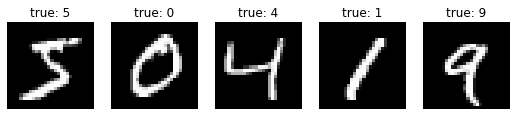

In [8]:
# Make a Dataset object
mnist_set = Dataset(mnist_all_X, mnist_all_y)

# Reshape the data
width = 28
categories = 10
mnist_set.shape(width, categories)
print("Feature and label shapes:", mnist_set.X.shape, mnist_set.y.shape)

# Visualize the first five images
Utility.plot_images(mnist_set, 5)

Splits on training, validation, & testing: (784, 49000) (784, 10500) (784, 10500)


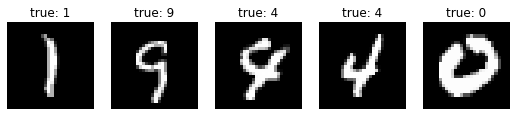

In [9]:
# Shuffle the data
mnist_set.shuffle()
Utility.plot_images(mnist_set, 5)

# Divide the data
mnist_set.divide()
print('Splits on training, validation, & testing:', 
      mnist_set.X_train.shape, mnist_set.X_valid.shape, mnist_set.X_test.shape)

## 2.3 Trying different models

### 2.3.1 Varying the learning rate

In [12]:
# Values to use throughout all models
batch = 100
epochs = 15

In [13]:
dims = (width*width, 128, 64, 10)
activ_fns = (Activation.relu, Activation.relu, Activation.softmax)

# Make a generic neural network with two hidden layers
p_128_64 = Perceptron(dims, activ_fns, Loss.cross_entropy)

# Different learning rates to test
lr_result = {}
lrs = (1e-4, 5e-4, 0.001, 0.005, 0.01)
for lr in lrs:
  p_128_64.reset() # Reinitialize parameters
  lr_result[lr] = Utility.train_epochs(p_128_64, mnist_set, lr, 
    epochs, batch, verbose=True)

Epoch 	Train loss 	Train acc 	Valid loss 	 Valid acc
0 	    4.818 	    0.101 	    4.055 	    0.119
1 	    3.772 	    0.142 	    3.510 	    0.163
2 	    3.325 	    0.181 	    3.128 	    0.200
3 	    2.987 	    0.220 	    2.828 	    0.241
4 	    2.718 	    0.256 	    2.588 	    0.278
5 	    2.501 	    0.293 	    2.392 	    0.315
6 	    2.323 	    0.327 	    2.231 	    0.346
7 	    2.174 	    0.358 	    2.095 	    0.375
8 	    2.048 	    0.387 	    1.980 	    0.402
9 	    1.939 	    0.411 	    1.880 	    0.426
10 	    1.845 	    0.434 	    1.793 	    0.448
11 	    1.762 	    0.454 	    1.717 	    0.468
12 	    1.689 	    0.473 	    1.648 	    0.488
13 	    1.623 	    0.491 	    1.587 	    0.504
14 	    1.564 	    0.508 	    1.532 	    0.519
Time elapsed (s): 28.7

Epoch 	Train loss 	Train acc 	Valid loss 	 Valid acc
0 	    3.404 	    0.210 	    2.420 	    0.314
1 	    2.100 	    0.385 	    1.820 	    0.449
2 	    1.663 	    0.487 	    1.507 	    0.528
3 	    1.410 	    0.554 	    1.311 	 

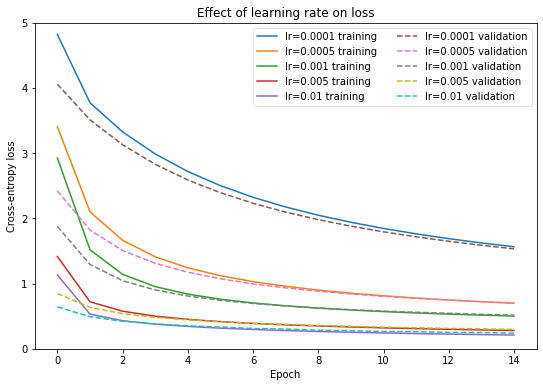

In [15]:
Utility.plot_results([lr_result[_][0] for _ in lrs],
    [lr_result[_][2] for _ in lrs],
    labels=['lr=' + str(lr) for lr in lrs],
    label_append=' training',
    ylabel='Cross-entropy loss', ymax=5,
    title='Effect of learning rate on loss')

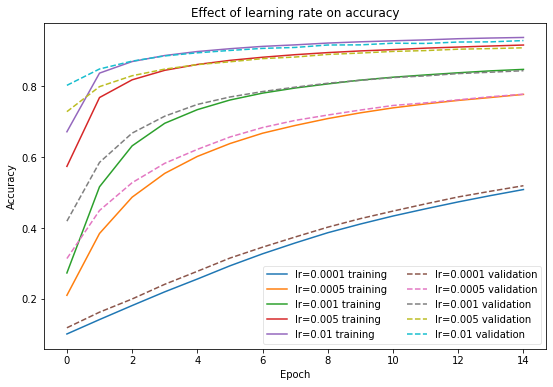

In [16]:
Utility.plot_results([lr_result[_][1] for _ in lrs],
    [lr_result[_][3] for _ in lrs],
    labels=['lr=' + str(lr) for lr in lrs],
    label_append=' training', ylabel='Accuracy',
    title='Effect of learning rate on accuracy')

Based on the validation results, using a learning rate of 0.01 performed best, as it had the lowest loss and highest accuracy when the architecture and number of epochs is held constant. 

Because the last model using a learning rate of 0.01 is still in memory, pass the test set forwards to vet the final performance.

In [17]:
# Generate batches from test data, pass through model
test_gen = mnist_set.make_batches(batch, 'test')
loss, acc = p_128_64.pass_data(test_gen, train_mode=False) 
print('Cross-entropy loss: {:.3f}\nAccuracy: {:.1f}%'.format(loss, acc*100))

Cross-entropy loss: 0.253
Accuracy: 92.4%


### 2.3.2 Varying the architecture

*   Number of hidden layers
*   Number of neurons per layer



In [18]:
# Define different architectures to try
lr_fixed = 0.002
arch_result = {}
dims_set = ((width*width, 64, 32, 10),
  (width*width, 256, 128, 10),
  (width*width, 128, 64, 32, 10),
  (width*width, 256, 128, 64, 10))
activ_fns_set = ((Activation.relu, Activation.relu, Activation.softmax),
  (Activation.relu, Activation.relu, Activation.softmax),
  (Activation.relu, Activation.relu, Activation.relu, Activation.softmax),
  (Activation.relu, Activation.relu, Activation.relu, Activation.softmax))

# Train models
for dims, activ_fns in zip(dims_set, activ_fns_set):
  p = Perceptron(dims, activ_fns, Loss.cross_entropy)
  arch_result[dims] = Utility.train_epochs(p, mnist_set, lr_fixed, 
    epochs, batch, verbose=False)

Time elapsed (s): 18.2

Time elapsed (s): 48.5

Time elapsed (s): 28.2

Time elapsed (s): 53.5



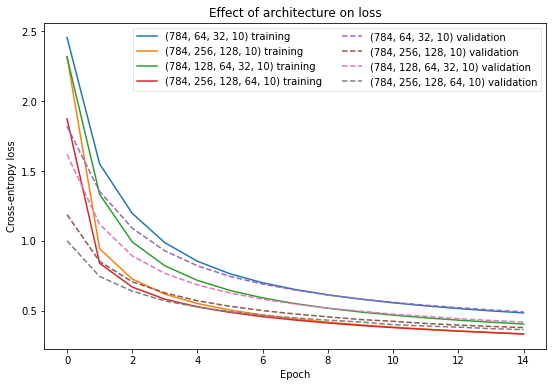

In [20]:
# Plot loss for the different architectures tried
Utility.plot_results([arch_result[_][0] for _ in dims_set],
    [arch_result[_][2] for _ in dims_set],
    labels=[str(dims) for dims in dims_set],
    label_append=' training', ylabel='Cross-entropy loss',
    title='Effect of architecture on loss')

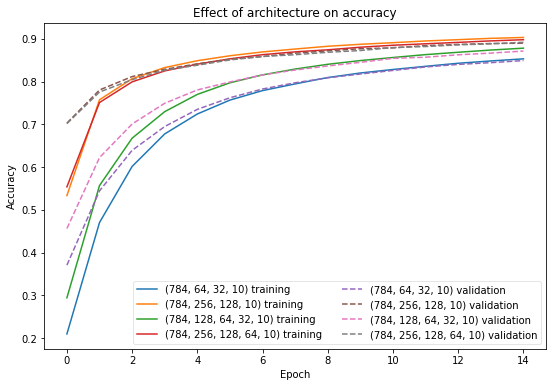

In [21]:
# Plot accuracy for different architectures tried
Utility.plot_results([arch_result[_][1] for _ in dims_set],
    [arch_result[_][3] for _ in dims_set],
    labels=[str(dims) for dims in dims_set],
    label_append=' training', ylabel='Accuracy',
    title='Effect of architecture on accuracy')

In [22]:
for dims in dims_set:
    print('{} -> Validation loss: {:.3f}, accuracy: {:.1f}'.format(
        dims, arch_result[dims][1][-1], arch_result[dims][3][-1]*100))

(784, 64, 32, 10) -> Validation loss: 0.853, accuracy: 84.9
(784, 256, 128, 10) -> Validation loss: 0.903, accuracy: 89.0
(784, 128, 64, 32, 10) -> Validation loss: 0.878, accuracy: 87.1
(784, 256, 128, 64, 10) -> Validation loss: 0.898, accuracy: 89.2


From these validation results, the second model with 2 hidden layers (dimensions 256, 128, respectively) and the fourth model with 3 hidden layers (dimensions of 256, 128, and 64, respectively), performed the approximately the best. They had similar accuracies and losses when other factors were held constant, such as the learning rate. For ease of testing, the fourth model was chosen as it is still in memory.

Below, the model performance is confirmed by using the test data.

In [23]:
# Generate batches from test data, pass through model
test_gen = mnist_set.make_batches(batch, 'test')
loss, acc = p.pass_data(test_gen, train_mode=False) 
print('Cross-entropy loss: {:.3f}\nAccuracy: {:.1f}%'.format(loss, acc*100))

Cross-entropy loss: 0.393
Accuracy: 88.4%


### 2.3.3 Varying the activation functions

In [24]:
# Using the architecture in section 2.3.1, vary the activation functions used
lr_fixed = 0.002
activ_result = {}
activ_p = {}
dims_fixed = (width*width, 128, 64, 10)
activ_fns_set = ((Activation.relu, Activation.relu, Activation.softmax),
  (Activation.sigmoid, Activation.sigmoid, Activation.softmax),
  (Activation.sigmoid, Activation.relu, Activation.softmax),
  (Activation.relu, Activation.sigmoid, Activation.softmax))

for activ_fns in activ_fns_set:
  p_activ = Perceptron(dims_fixed, activ_fns, Loss.cross_entropy)
  activ_result[activ_fns] = Utility.train_epochs(p_activ, mnist_set, lr_fixed, 
    epochs, batch, verbose=False)

  # Save model
  activ_p[activ_fns] = p_activ

Time elapsed (s): 31.6

Time elapsed (s): 43.1

Time elapsed (s): 38.8

Time elapsed (s): 30.0



In [25]:
# Clean up tuples for labels and legend
activ_to_str = lambda a: [str(_).split('Activation.')[1].split(' at')[0] for 
_ in a]
activ_fns_str = ['-'.join(activ_to_str(_)) for _ in activ_fns_set]

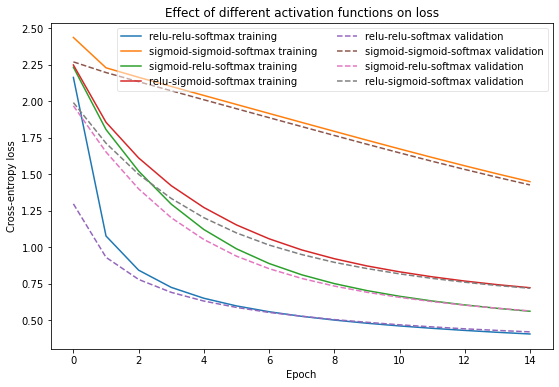

In [26]:
Utility.plot_results([activ_result[_][0] for _ in activ_fns_set],
    [activ_result[_][2] for _ in activ_fns_set],
    labels=[str(_) for _ in activ_fns_str],
    ylabel='Cross-entropy loss', label_append=' training',
    title='Effect of different activation functions on loss')

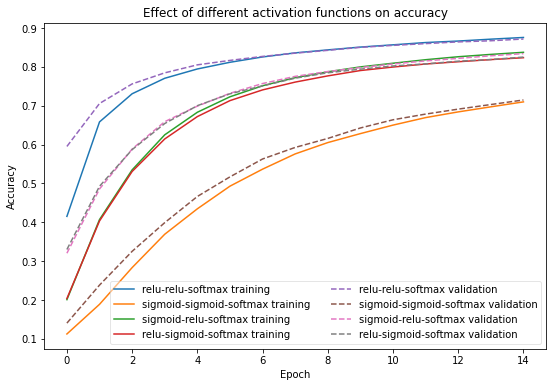

In [27]:
Utility.plot_results([activ_result[_][1] for _ in activ_fns_set],
    [activ_result[_][3] for _ in activ_fns_set],
    labels=[str(_) for _ in activ_fns_str],
    ylabel='Accuracy', label_append=' training',
    title='Effect of different activation functions on accuracy')

In [28]:
# Validating: architecture vs. loss
print('Architecture, Validation loss, Validation accuracy')
for activ_fns, activ_str in zip(activ_fns_set, activ_fns_str):
    print('{}, {:.3f}, {:.1f}%'.format(
        activ_str, 
        activ_result[activ_fns][1][-1],
        activ_result[activ_fns][3][-1]*100))

Architecture, Validation loss, Validation accuracy
relu-relu-softmax, 0.876, 87.2%
sigmoid-sigmoid-softmax, 0.710, 71.5%
sigmoid-relu-softmax, 0.837, 83.4%
relu-sigmoid-softmax, 0.823, 82.5%


Based on the validation results, the model with ReLU activation functions in both of its hidden layers performed best when the learning rate, architecture, and number of epochs are held constant. In addition, it is most efficient in training time, as is expected. Thus, the model with ReLU in both of its hidden layers is selected.

Below, the chosen model's performance is reported by using the test data.

In [29]:
# Generate batches from test data, pass through model
chosen_p = activ_p[(Activation.relu, Activation.relu, Activation.softmax)]
test_gen = mnist_set.make_batches(batch, 'test')
loss, acc = chosen_p.pass_data(test_gen, train_mode=False) 
print('Cross-entropy loss: {:.3f}\nAccuracy: {:.1f}%'.format(loss, acc*100))

Cross-entropy loss: 0.427
Accuracy: 87.0%


### 2.3.4 Try hinge loss instead of cross-entropy & softmax

In [30]:
# Set the hinge_and_logits argument to disregard the softmax output and 
# apply hinge loss to the logits instead.
p_softmax = Perceptron((width*width, 128, 64, 10), 
    (Activation.relu, Activation.relu, Activation.softmax), Loss.cross_entropy)
softmax_result = Utility.train_epochs(p_softmax, mnist_set, 0.002, 
    epochs=15, batch_size=100, hinge_and_logits=False)

p_hinge = Perceptron((width*width, 128, 64, 10), 
    (Activation.relu, Activation.relu, Activation.softmax), Loss.hinge_loss)
hinge_result = Utility.train_epochs(p_hinge, mnist_set, 0.002, 
    epochs=15, batch_size=100, hinge_and_logits=True)

Epoch 	Train loss 	Train acc 	Valid loss 	 Valid acc
0 	    2.230 	    0.403 	    1.291 	    0.590
1 	    1.071 	    0.653 	    0.923 	    0.703
2 	    0.833 	    0.730 	    0.770 	    0.756
3 	    0.714 	    0.772 	    0.681 	    0.786
4 	    0.639 	    0.798 	    0.622 	    0.806
5 	    0.587 	    0.817 	    0.578 	    0.821
6 	    0.548 	    0.830 	    0.545 	    0.833
7 	    0.517 	    0.840 	    0.519 	    0.843
8 	    0.491 	    0.849 	    0.497 	    0.847
9 	    0.470 	    0.856 	    0.480 	    0.853
10 	    0.452 	    0.861 	    0.465 	    0.858
11 	    0.436 	    0.867 	    0.450 	    0.861
12 	    0.422 	    0.871 	    0.438 	    0.866
13 	    0.410 	    0.875 	    0.427 	    0.869
14 	    0.399 	    0.879 	    0.417 	    0.872
Time elapsed (s): 28.8

Epoch 	Train loss 	Train acc 	Valid loss 	 Valid acc
0 	    4.927 	    0.603 	    3.820 	    0.731
1 	    3.474 	    0.771 	    3.277 	    0.788
2 	    3.107 	    0.813 	    3.018 	    0.817
3 	    2.892 	    0.835 	    2.852 	 

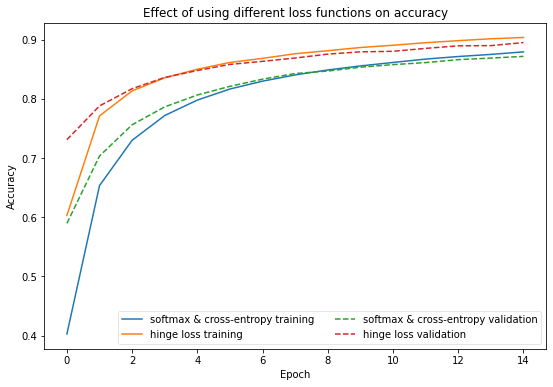

In [31]:
Utility.plot_results([softmax_result[1], hinge_result[1]],
[softmax_result[3], hinge_result[3]],
labels=['softmax & cross-entropy', 'hinge loss'],
ylabel='Accuracy', label_append=' training',
title='Effect of using different loss functions on accuracy')

Using hinge loss and its derivative to train a model appears to achieve greater accuracy than using softmax and cross-entropy loss using the same learning rate and number of epochs. Thus, the model with hinge loss is chosen to test.

In [32]:
# Generate batches from test data, pass through model
test_gen = mnist_set.make_batches(batch_size=100, group='test')
loss, acc = p_hinge.pass_data(test_gen, train_mode=False) 
print('Hinge loss: {:.3f}\nAccuracy: {:.1f}%'.format(loss, acc*100))

Hinge loss: 2.308
Accuracy: 89.5%


# 3. Appendix

Simple tests to check basic functionality with hand calculations.

Hinge loss examples from class on 1/20/22

In [33]:
# 3-class classification example
z_ex1 = np.array([-3.7, 5, 7]).T
print('Target class is 3, hinge loss={:0.1f} \tif 2, {:0.1f} \tif 1, {:0.1f}'.format(
    Loss.hinge_loss(z_ex1, np.array([0, 0, 1]).T),
    Loss.hinge_loss(z_ex1, np.array([0, 1, 0]).T),
    Loss.hinge_loss(z_ex1, np.array([1, 0, 0]).T)))

Target class is 3, hinge loss=0.0 	if 2, 3.0 	if 1, 21.4


In [34]:
# 4-class classification example
z_ex2 = np.array([2.5, 2.0, 2.7, 1.7]).T
print('Target class is 2, hinge loss={:0.1f}'.format(
    Loss.hinge_loss(z_ex2, np.array([0, 1, 0, 0]).T)))

Target class is 2, hinge loss=3.9


Hinge loss example from class on 3/1/22

In [35]:
z_ex3 = np.array([1., 1.7, -0.5, 2.7]).T
print('Target class is 2, hinge loss={:0.1f}. Derivative wrt z={}'.format(
    Loss.hinge_loss(z_ex3, np.array([0, 1, 0, 0]).T),
    Loss.hinge_loss(z_ex3, np.array([0, 1, 0, 0]).T, derive=True)))

Target class is 2, hinge loss=2.3. Derivative wrt z=[ 1 -2  0  1]


Check softmax and cross-entropy methods

In [36]:
# Create output layer aggregation, activate through softmax
z_sample = np.array([[-1, 0, 3, 5], [-0.1, 1, 2, 3], 
    [1, 0.1, 0.2, 0.5]]).reshape(3, -1).T
yhat_sample = Activation.softmax(z_sample)
print('predictions:', yhat_sample)

# Make class 3 the target class
y_sample = np.array([[0, 0, 1, 0], [0, 0, 0, 1], 
    [1, 0, 0, 0]]).reshape(3, -1).T
print('cross-entropy loss:', Loss.cross_entropy(yhat_sample, y_sample), 
    '\nactual labels:', y_sample)

# Take cross-entropy loss gradient wrt outputs
grad_chain = Loss.cross_entropy(yhat_sample, y_sample, derive=1)

# Take loss gradient wrt logits by using chain rule (backup thru softmax)
deriv_softmax = Activation.softmax(z_sample, y_sample, derive=1)
grad_chain = grad_chain * deriv_softmax
print('gradient wrt logits:\n', grad_chain)

# Should be the same as shortcut when using both softmax and cross-entropy
print(np.isclose(grad_chain, yhat_sample - y_sample).all())

predictions: [[0.0021657  0.02909659 0.40610303]
 [0.00588697 0.08741099 0.16510917]
 [0.11824302 0.23760771 0.18247386]
 [0.87370431 0.64588471 0.24631394]]
cross-entropy loss: 1.157723745494379 
actual labels: [[0 0 1]
 [0 0 0]
 [1 0 0]
 [0 1 0]]
gradient wrt logits:
 [[ 0.0021657   0.02909659 -0.59389697]
 [ 0.00588697  0.08741099  0.16510917]
 [-0.88175698  0.23760771  0.18247386]
 [ 0.87370431 -0.35411529  0.24631394]]
True


Compute accuracy on two examples, one predicted correctly and one not:

In [37]:
yhat = np.array(((0.2, 0.5, 0.3), (0.7, 0.2, 0.1))).T
y = np.array(((0, 1, 0), (0, 1, 0))).T
Loss.accuracy(yhat, y)

0.5

Informal MLP problem given at the end of class, 1/25/22:

In [43]:
p = Perceptron((4, 3, 2, 4), 
               (Activation.relu, Activation.sigmoid, Activation.softmax), 
               Loss.cross_entropy, init_with_normal=True)
p[1].w = np.array([[1.,0,0,0], [0,1,0,0], [0,0,1,0]])
p[2].w = np.array([[1.,0,0], [0,1,0]])
p[3].w = np.array([[1.,0], [0,1], [0,0], [0,0]])
p.zero_biases()

# Check forward path
p.forward(np.array([1, 0, 1, 0]).reshape(-1, 1), batch_size=1)
for i in range(1, len(p.dims)):
  print('Layer', i,'-> a =\n', p[i].a)

Layer 1 -> a =
 [[1.]
 [0.]
 [1.]]
Layer 2 -> a =
 [[0.73105858]
 [0.5       ]]
Layer 3 -> a =
 [[0.36278004]
 [0.28793597]
 [0.17464199]
 [0.17464199]]


In [44]:
# Check backpropagation
y = np.array([0., 1., 0., 0.]).reshape(-1, 1) # Dummy one-hot label
print('p[1].w before backprop\n', p[1].w)
p.backward(y, lr=0.5, batch_size=1)
print('p[1].w after backprop\n', p[1].w)
print('New output:\n', Activation.softmax(p[3].w @ p[2].a + p[3].b))

p[1].w before backprop
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
p[1].w after backprop
 [[ 9.99259692e-01  0.00000000e+00 -7.40308157e-04  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.09998947e-02  0.00000000e+00  1.01099989e+00  0.00000000e+00]]
New output:
 [[0.23755303]
 [0.49192843]
 [0.13525927]
 [0.13525927]]
